#  Vanilla Untrained Model
This notebook is designed as a easy einterface to call the functions that we have defined

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data
from LCModels import LCNECortexFCN, LCNECortexRNN, LCNECortexFitter, FeedForwardNN, RecurrentNet
from simulate import run_simulation, render_plot

Let's defined the two types of models that we have first

In [2]:
lambda_cortex = 0.1
hidden_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_FCN = LCNECortexFCN(lambda_cortex).to(device)
model_RNN = LCNECortexRNN(hidden_size).to(device)

Then let's setup the simulation constants we want

In [3]:
time_steps = 100
conditions = ["baseline", "acute_stress", "chronic_stress", "top_down_control"]

In [4]:
# results = {cond: run_simulation(model_FCN, device, time_steps, cond) for cond in conditions}
# render_plot(results)
# results = {cond: run_simulation(model_RNN, device, time_steps, cond) for cond in conditions}
# render_plot(results)

# Data Preparation

In [5]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

# Baseline Fully Connected Neural Network

In [6]:
features = ['Condition', 'PreEvent_PupilMax', 'TrialEvent', 'onset', 'duration']
target = ['Event_PupilDilation']

df_clean = df_behavior[features + target].dropna().reset_index(drop=True)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_clean[['Condition', 'TrialEvent']])
encoded_feature_names = encoder.get_feature_names_out(['Condition', 'TrialEvent'])

scaler_X = StandardScaler()
scaled_features = scaler_X.fit_transform(df_clean[['PreEvent_PupilMax', 'onset', 'duration']])

X_scaled = pd.DataFrame(scaled_features, columns=['PreEvent_PupilMax', 'onset', 'duration'])
X_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names)

X_scaled.reset_index(drop=True, inplace=True)
X_encoded.reset_index(drop=True, inplace=True)
X = pd.concat([X_scaled, X_encoded], axis=1)

# scaler_Y = StandardScaler()
# Y = scaler_Y.fit_transform(df_clean[['Event_PupilDilation']].values.reshape(-1,1))

scaler_Y = MinMaxScaler(feature_range=(-1, 1))
Y = scaler_Y.fit_transform(df_clean[['Event_PupilDilation']].values.reshape(-1, 1))

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).squeeze()

print(f"X Shape: {X_tensor.shape}, Y Shape: {Y_tensor.shape}")
print(f"Y Min: {Y_tensor.min().item()}, Y Max: {Y_tensor.max().item()}")  # Check Scaling

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


Epoch 0, Loss: 0.10123475641012192
Epoch 100, Loss: 0.048046160489320755
Epoch 200, Loss: 0.047038547694683075
Epoch 300, Loss: 0.046097926795482635
Epoch 400, Loss: 0.044953979551792145
Epoch 500, Loss: 0.04450967535376549
Epoch 600, Loss: 0.04399445652961731
Epoch 700, Loss: 0.04325670748949051
Epoch 800, Loss: 0.04310345649719238
Epoch 900, Loss: 0.04284635931253433


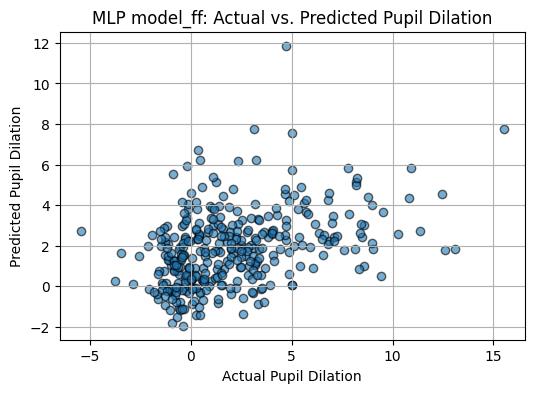

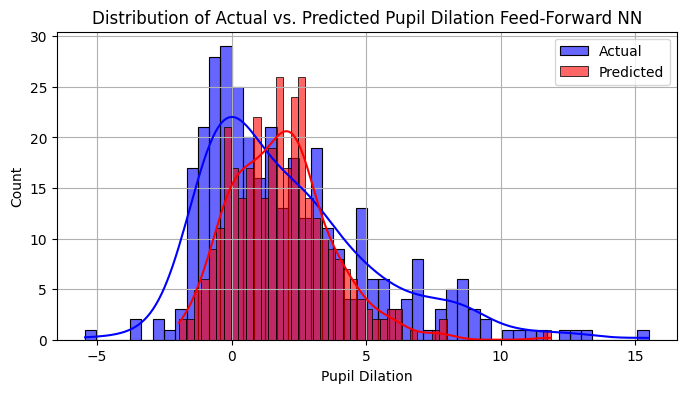

Pearson Correlation: 0.3975


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

input_size = X_tensor.shape[1]
model_ff = FeedForwardNN(input_size)
optimizer = optim.Adam(model_ff.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model_ff(X_train)
    loss = loss_fn(Y_pred, Y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

with torch.no_grad():
    Y_test_pred = model_ff(X_test)

Y_test_pred = scaler_Y.inverse_transform(Y_test_pred.cpu().numpy())
Y_test_actual = scaler_Y.inverse_transform(Y_test.cpu().numpy().reshape(-1, 1))

# Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(6, 4))
plt.scatter(Y_test_actual, Y_test_pred, alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("MLP model_ff: Actual vs. Predicted Pupil Dilation")
plt.grid(True)
plt.show()

# Convert predictions to DataFrame for visualization
df_predictions = pd.DataFrame({'PupilPred': Y_test_pred.flatten()})
df_actual = pd.DataFrame({'Event_PupilDilation': Y_test_actual.flatten()})

# Histogram: Distribution of Actual vs. Predicted
plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation Feed-Forward NN")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

# LCNECortex Model

In [8]:
model_lc = LCNECortexFitter(lambda_cortex=0.5)
optimizer = torch.optim.Adam(model_lc.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50)
loss_fn = nn.MSELoss()

epochs = 600
batch_size = 64
num_batches = X_tensor.shape[0] // batch_size

# for epoch in range(epochs):
#     epoch_loss = 0.0

#     for i in range(num_batches):
#         optimizer.zero_grad()

#         # batch
#         start = i * batch_size
#         end = start + batch_size

#         X_batch = X_tensor[start:end, :]
#         Y_batch = Y_tensor[start:end]

#         # initilize LC and Cortex states (batch_size,)
#         prev_LC = torch.zeros(batch_size)
#         prev_Cortex = torch.zeros(batch_size)

#         LC_pred, NE_pred, C_pred, Pupil_pred = model_lc(X_batch, prev_LC, prev_Cortex)
#         loss = loss_fn(Pupil_pred, Y_batch)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     scheduler.step(epoch_loss / num_batches)

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {epoch_loss / num_batches:.4f}, LR: {optimizer.param_groups[0]['lr']}")

In [9]:
optimizer = optim.AdamW(model_lc.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

epochs = 1500
for epoch in range(epochs):
    
    for i in range(num_batches):
        optimizer.zero_grad()
        # batch
        start = i * batch_size
        end = start + batch_size

        X_batch = X_tensor[start:end, :]
        Y_batch = Y_tensor[start:end]
        prev_LC = torch.zeros(batch_size)
        prev_Cortex = torch.zeros(batch_size)
        
        LC_pred, NE_pred, C_pred, Pupil_pred = model_lc(X_batch, prev_LC, prev_Cortex)
        
        loss = loss_fn(Pupil_pred, Y_batch)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_lc.parameters(), max_norm=1.0) 
        optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.039116427302360535
Epoch 100, Loss: 0.034761760383844376
Epoch 200, Loss: 0.03458508849143982
Epoch 300, Loss: 0.034765079617500305
Epoch 400, Loss: 0.03849262371659279
Epoch 500, Loss: 0.03477375954389572
Epoch 600, Loss: 0.03494666889309883
Epoch 700, Loss: 0.03477729484438896
Epoch 800, Loss: 0.03501524403691292
Epoch 900, Loss: 0.03477909415960312
Epoch 1000, Loss: 0.035122111439704895
Epoch 1100, Loss: 0.03478015214204788
Epoch 1200, Loss: 0.035082027316093445
Epoch 1300, Loss: 0.0347808338701725
Epoch 1400, Loss: 0.035118766129016876


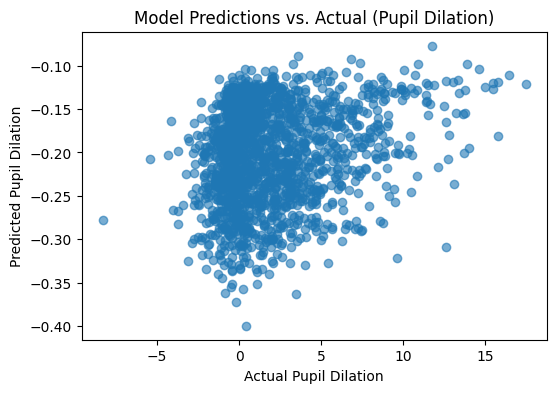

In [10]:
prev_LC = torch.zeros(X_tensor.shape[0])  
prev_Cortex = torch.zeros(X_tensor.shape[0])

with torch.no_grad():
    _, _, _, Pupil_pred = model_lc(X_tensor, prev_LC, prev_Cortex)

df_predictions = pd.DataFrame({'PupilPred': Pupil_pred.detach().cpu().numpy()})

df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6)
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("Model Predictions vs. Actual (Pupil Dilation)")
plt.show()


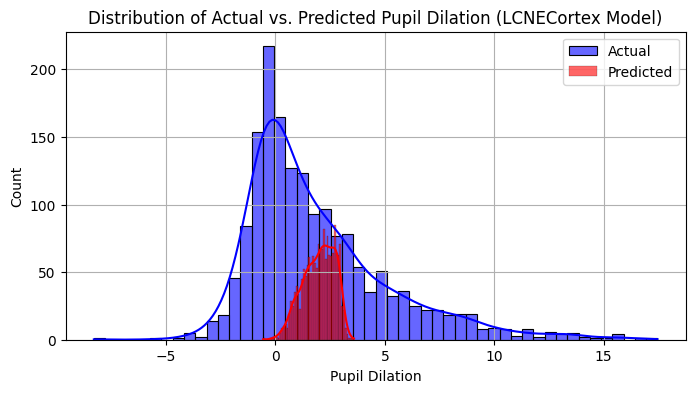

In [11]:
df_predictions['PupilPred'] = scaler_Y.inverse_transform(df_predictions[['PupilPred']])

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (LCNECortex Model)")
plt.grid(True)
plt.show()

In [12]:
corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

Pearson Correlation: 0.2052


# Recuren Networks

In [13]:
# Convert input data into sequences
X_rnn = X_tensor.unsqueeze(1) 
Y_rnn = Y_tensor.unsqueeze(1) 

print(f"X_rnn Shape: {X_rnn.shape}, Y_rnn Shape: {Y_rnn.shape}")

X_rnn Shape: torch.Size([1699, 1, 7]), Y_rnn Shape: torch.Size([1699, 1])


In [14]:
model_rnn = RecurrentNet(input_size=X_rnn.shape[2])
optimizer = optim.Adam(model_rnn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model_rnn(X_rnn)
    loss = loss_fn(Y_pred, Y_rnn)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.1312
Epoch 100, Loss: 0.0513
Epoch 200, Loss: 0.0504
Epoch 300, Loss: 0.0495
Epoch 400, Loss: 0.0488
Epoch 500, Loss: 0.0482
Epoch 600, Loss: 0.0478
Epoch 700, Loss: 0.0476
Epoch 800, Loss: 0.0474
Epoch 900, Loss: 0.0473
Epoch 1000, Loss: 0.0470
Epoch 1100, Loss: 0.0468
Epoch 1200, Loss: 0.0466
Epoch 1300, Loss: 0.0465
Epoch 1400, Loss: 0.0465
Epoch 1500, Loss: 0.0463
Epoch 1600, Loss: 0.0462
Epoch 1700, Loss: 0.0462
Epoch 1800, Loss: 0.0461
Epoch 1900, Loss: 0.0460


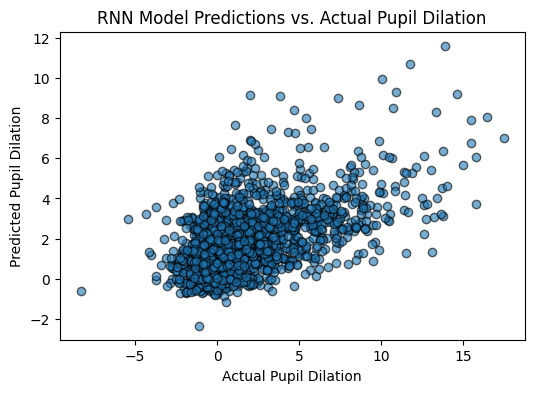

In [15]:
with torch.no_grad():
    Y_pred_rnn = model_rnn(X_rnn)

df_predictions = pd.DataFrame({'PupilPred': scaler_Y.inverse_transform(Y_pred_rnn.cpu().numpy().reshape(-1, 1)).squeeze()})
df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("RNN Model Predictions vs. Actual Pupil Dilation")
plt.show()


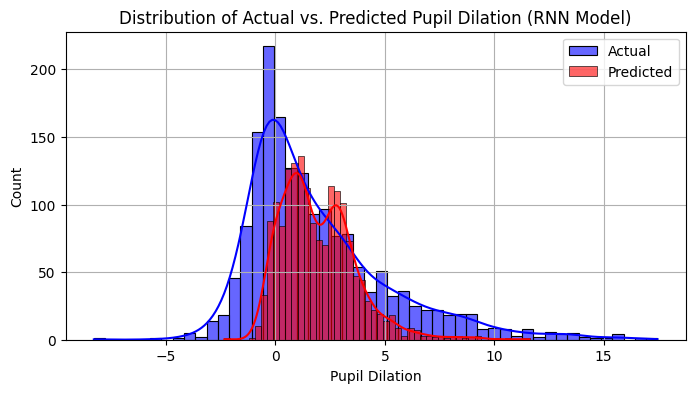

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (RNN Model)")
plt.grid(True)
plt.show()


# Analysis for Feed-Forward Neural Networks

In [17]:
input_size = X_tensor.shape[1]

with torch.no_grad():
    predictions, act1, act2 = model_ff(X_tensor, return_activations=True)

act1_np = act1.cpu().numpy()
act2_np = act2.cpu().numpy()

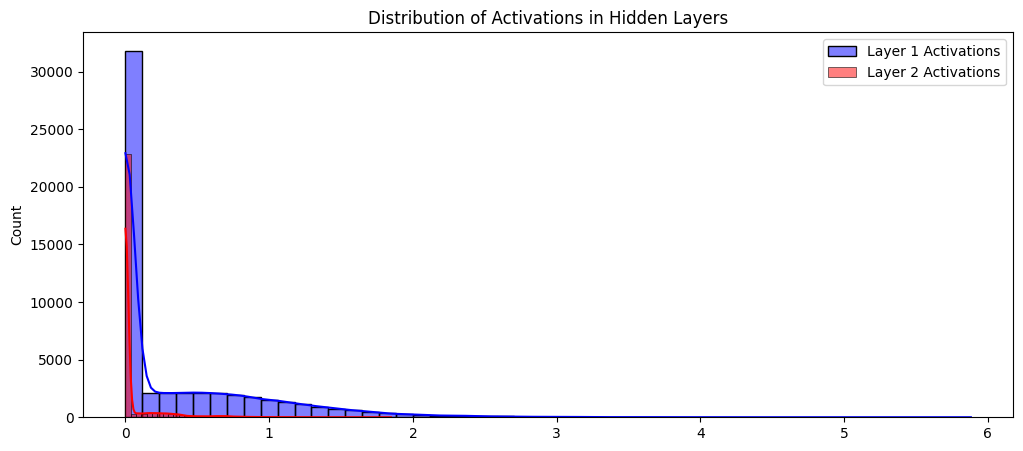

In [18]:
plt.figure(figsize=(12, 5))
sns.histplot(act1_np.flatten(), bins=50, kde=True, color='blue', label="Layer 1 Activations")
sns.histplot(act2_np.flatten(), bins=50, kde=True, color='red', label="Layer 2 Activations")
plt.legend()
plt.title("Distribution of Activations in Hidden Layers")
plt.show()

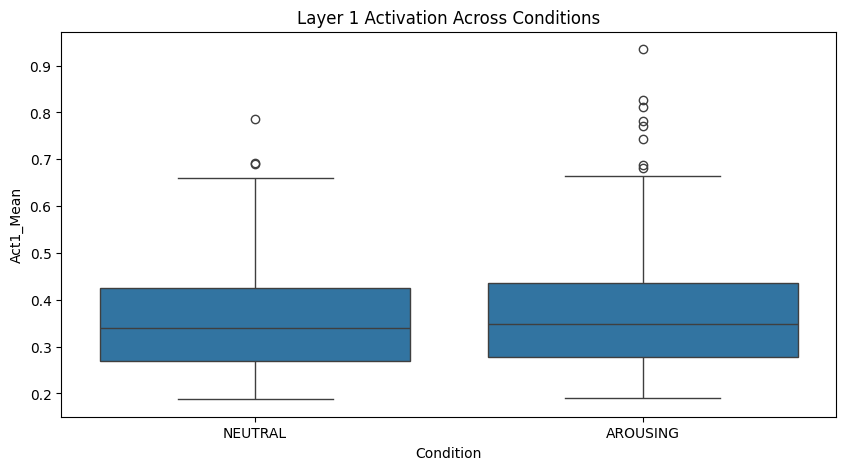

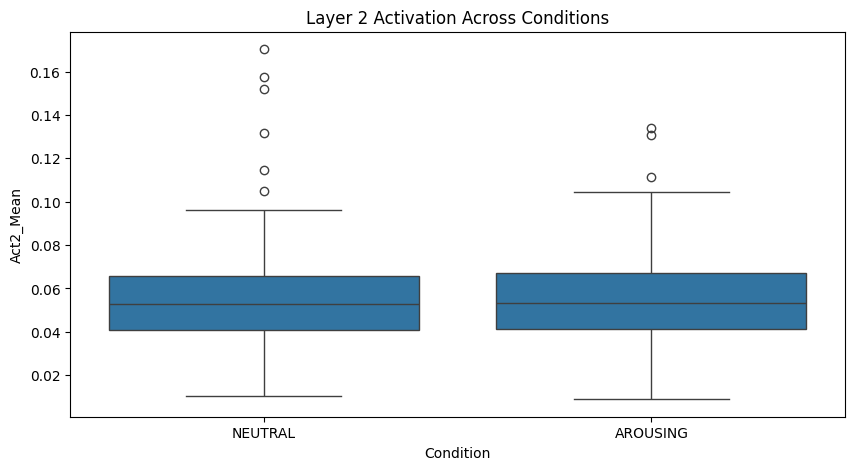

In [19]:
df_filtered = df_behavior.iloc[:X_tensor.shape[0]].copy()

df_filtered['Act1_Mean'] = np.mean(act1_np, axis=1)
df_filtered['Act2_Mean'] = np.mean(act2_np, axis=1)

plt.figure(figsize=(10, 5))
sns.boxplot(x="Condition", y="Act1_Mean", data=df_filtered)
plt.title("Layer 1 Activation Across Conditions")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x="Condition", y="Act2_Mean", data=df_filtered)
plt.title("Layer 2 Activation Across Conditions")
plt.show()


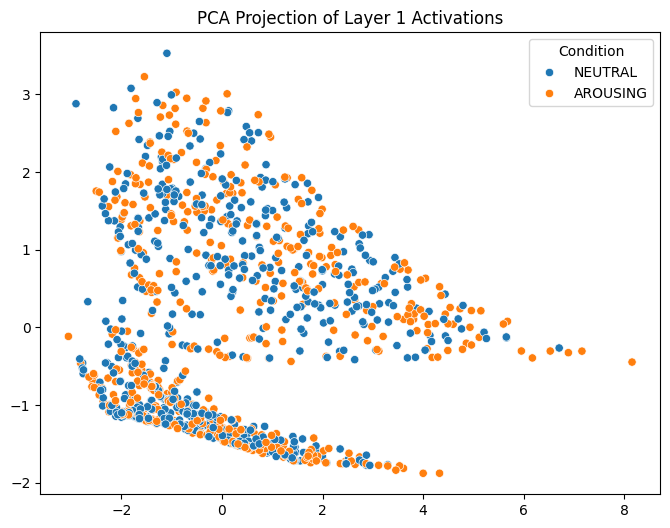

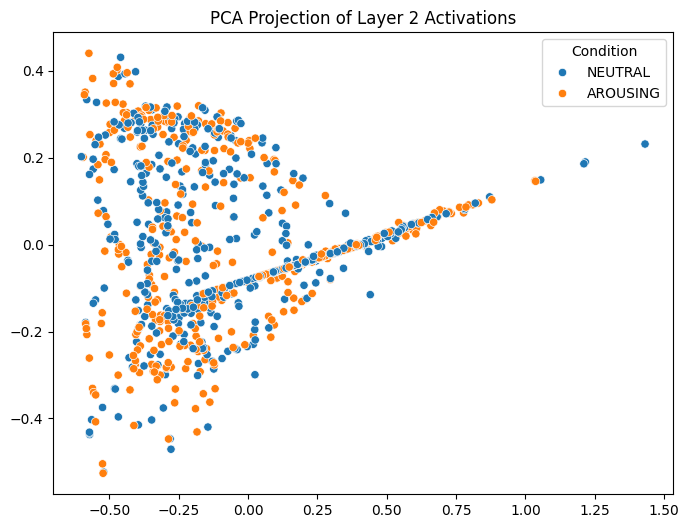

In [20]:
pca = PCA(n_components=2)
act1_pca = pca.fit_transform(act1_np)
act2_pca = pca.fit_transform(act2_np)

plt.figure(figsize=(8,6))
sns.scatterplot(x=act1_pca[:,0], y=act1_pca[:,1], hue=df_filtered["Condition"])
plt.title("PCA Projection of Layer 1 Activations")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=act2_pca[:,0], y=act2_pca[:,1], hue=df_filtered["Condition"])
plt.title("PCA Projection of Layer 2 Activations")
plt.show()

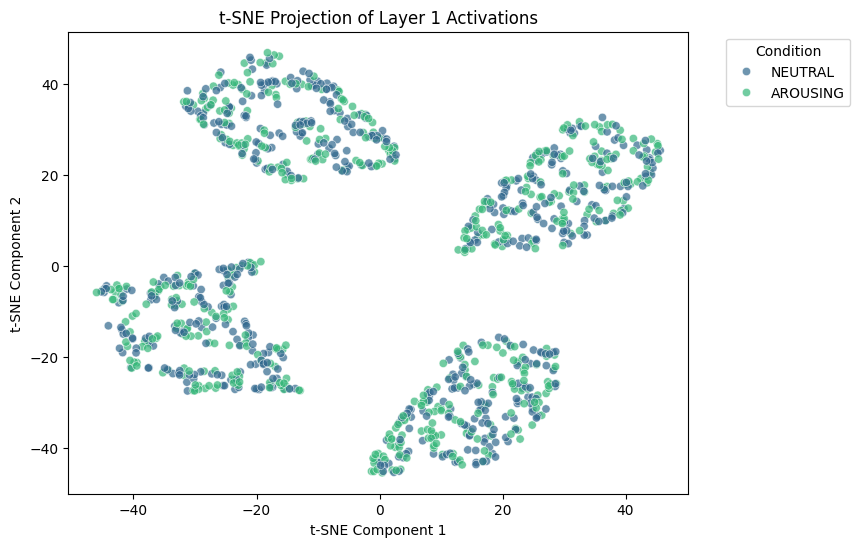

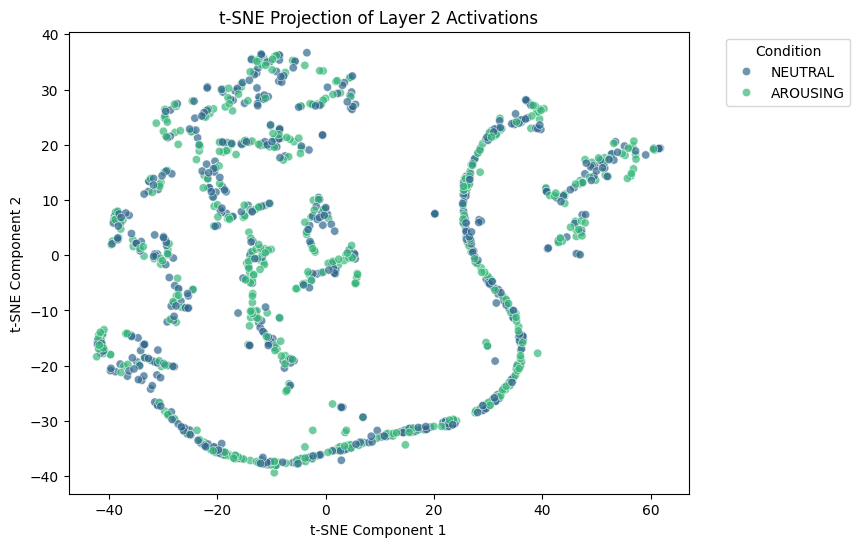

In [21]:
df_filtered = df_behavior.iloc[:act1_np.shape[0]].copy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act1_tsne = tsne.fit_transform(act1_np)
act2_tsne = tsne.fit_transform(act2_np)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act1_tsne[:, 0], y=act1_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)

plt.title("t-SNE Projection of Layer 1 Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act2_tsne[:, 0], y=act2_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)

plt.title("t-SNE Projection of Layer 2 Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Analysis for Recurrent Networks

In [22]:
with torch.no_grad():
    _, hidden_states = model_rnn.rnn(X_rnn)
    act_rnn = hidden_states.squeeze(0).cpu().numpy()

print(f"RNN Hidden Activations Shape: {act_rnn.shape}")

RNN Hidden Activations Shape: (1699, 32)


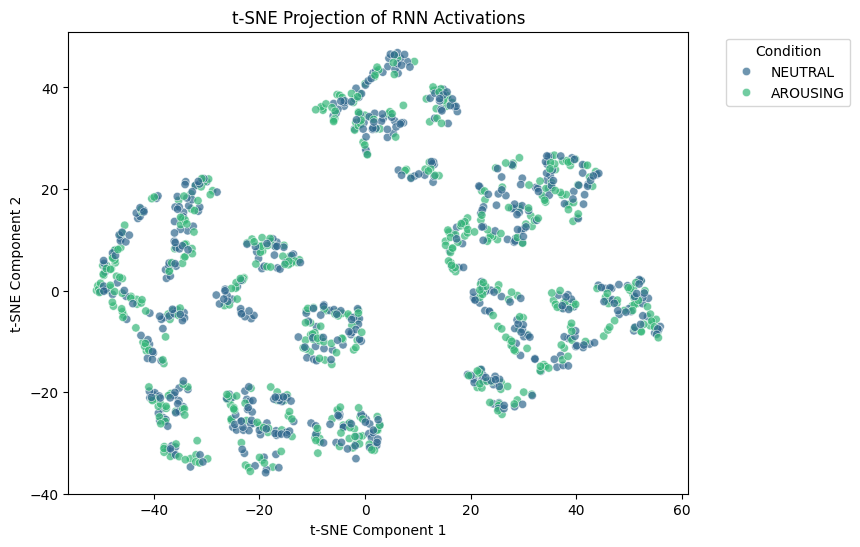

In [23]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_rnn_tsne = tsne.fit_transform(act_rnn)

df_filtered = df_behavior.iloc[:act_rnn.shape[0]].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_rnn_tsne[:, 0], y=act_rnn_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)

plt.title("t-SNE Projection of RNN Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


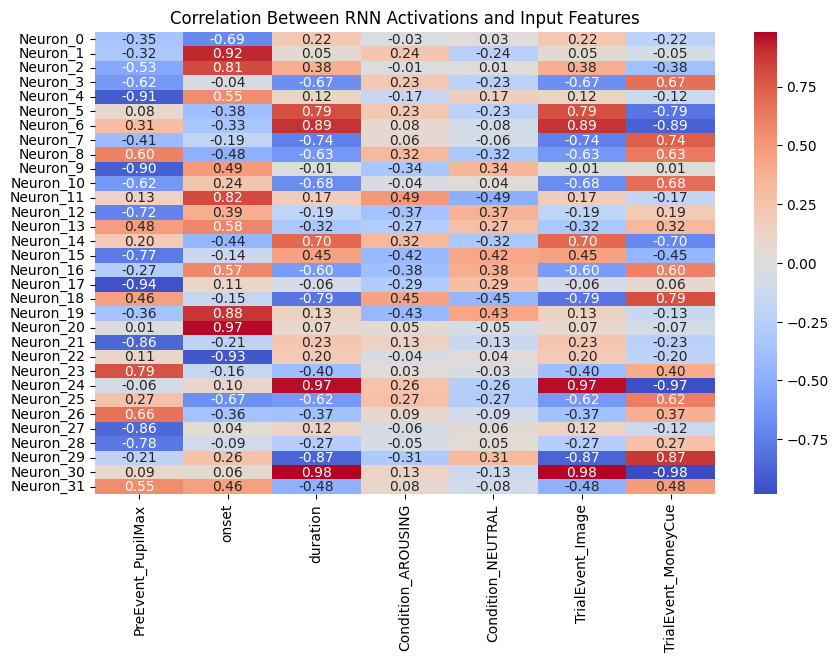

In [24]:
df_activations = pd.DataFrame(act_rnn, columns=[f"Neuron_{i}" for i in range(act_rnn.shape[1])])

df_correlation = pd.concat([df_activations, X], axis=1).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(df_correlation.iloc[:act_rnn.shape[1], act_rnn.shape[1]:], cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Correlation Between RNN Activations and Input Features")
plt.show()

# Analysis for LCNECortex Model

In [25]:
with torch.no_grad():
    LC_activations, NE_activations, C_activations, _ = model_lc(X_tensor, prev_LC, prev_Cortex)

act_lc = LC_activations.cpu().numpy()
act_ne = NE_activations.cpu().numpy()
act_cortex = C_activations.cpu().numpy()

print(f"LC Activations: Mean={act_lc.mean():.4f}, Std={act_lc.std():.4f}")
print(f"NE Activations: Mean={act_ne.mean():.4f}, Std={act_ne.std():.4f}")
print(f"Cortex Activations: Mean={act_cortex.mean():.4f}, Std={act_cortex.std():.4f}")

act_lc.shape, act_ne.shape, act_cortex.shape

LC Activations: Mean=-0.0014, Std=0.0000
NE Activations: Mean=0.5000, Std=0.0000
Cortex Activations: Mean=-0.0095, Std=0.2683


((1699,), (1699,), (1699,))

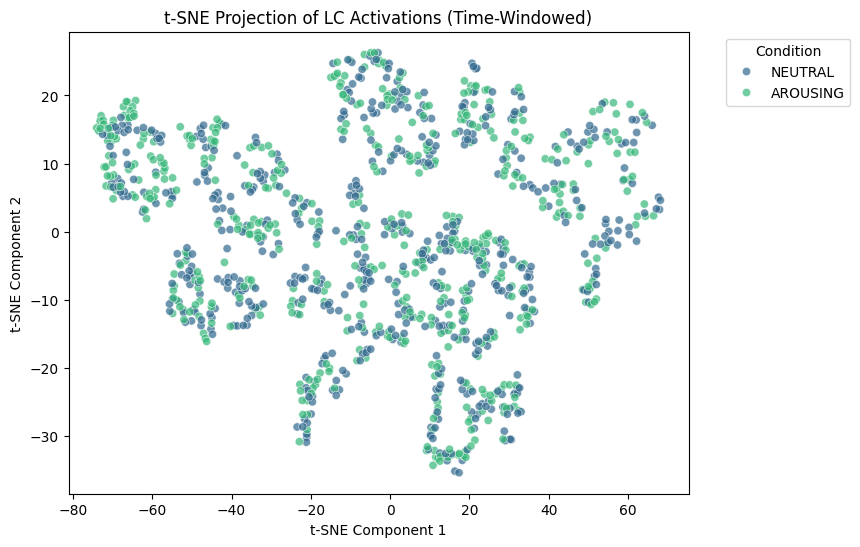

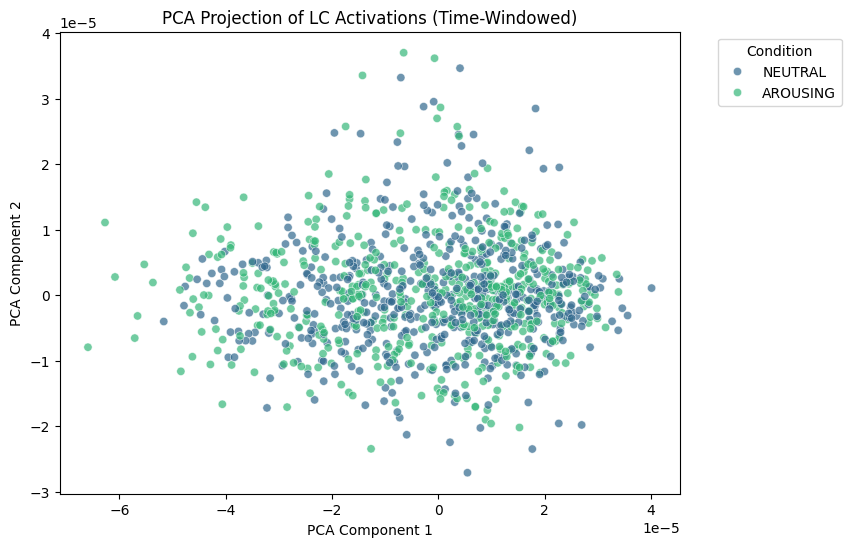

In [26]:
window_size = 2
act_lc_windowed = np.array([act_lc[i:i+window_size] for i in range(len(act_lc) - window_size)])

pca = PCA(n_components=2)
act_lc_pca = pca.fit_transform(act_lc_windowed)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
lc_tsne = tsne.fit_transform(act_lc_pca)

df_filtered = df_behavior.iloc[:lc_tsne.shape[0]].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=lc_tsne[:, 0], y=lc_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of LC Activations (Time-Windowed)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_lc_pca[:, 0], y=act_lc_pca[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title("PCA Projection of LC Activations (Time-Windowed)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

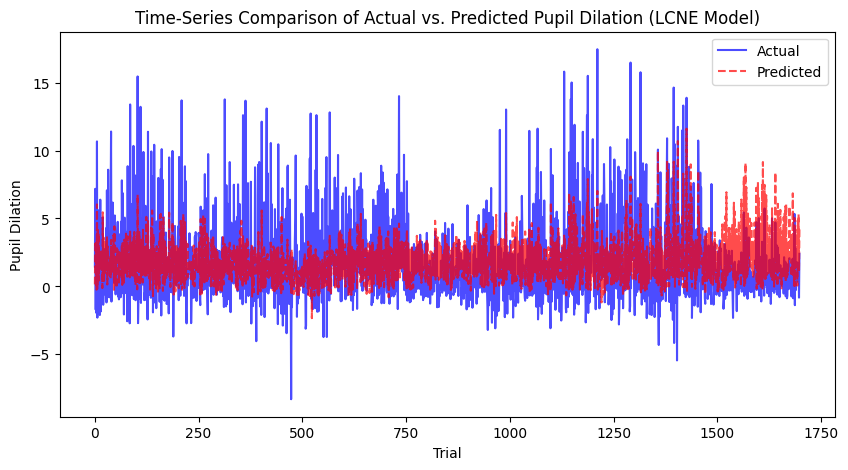

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(df_actual['Event_PupilDilation'].values, label="Actual", color='blue', alpha=0.7)
plt.plot(df_predictions['PupilPred'].values, label="Predicted", color='red', linestyle="dashed", alpha=0.7)

plt.xlabel("Trial")
plt.ylabel("Pupil Dilation")
plt.legend()
plt.title("Time-Series Comparison of Actual vs. Predicted Pupil Dilation (LCNE Model)")
plt.show()

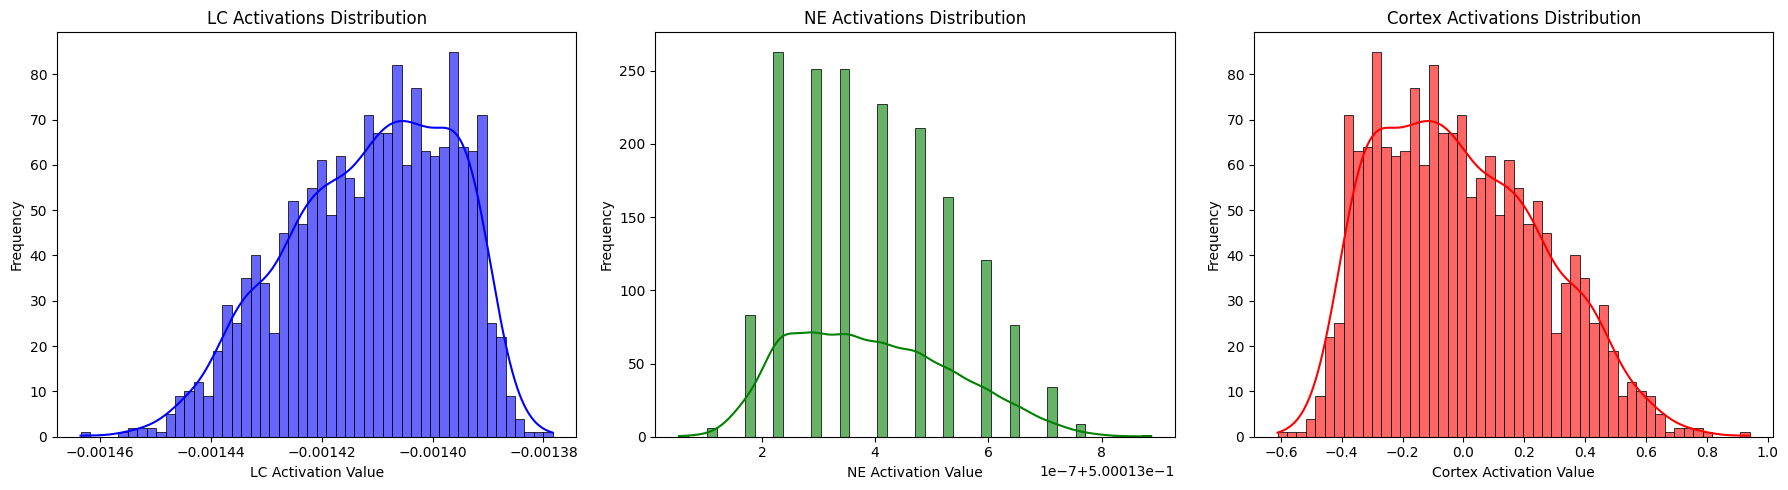

In [28]:
act_lc = LC_activations.cpu().numpy().flatten()
act_ne = NE_activations.cpu().numpy().flatten()
act_cortex = C_activations.cpu().numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LC activations
sns.histplot(act_lc, bins=50, kde=True, ax=axes[0], color="blue", alpha=0.6)
axes[0].set_title("LC Activations Distribution")
axes[0].set_xlabel("LC Activation Value")
axes[0].set_ylabel("Frequency")

# NE activations
sns.histplot(act_ne, bins=50, kde=True, ax=axes[1], color="green", alpha=0.6)
axes[1].set_title("NE Activations Distribution")
axes[1].set_xlabel("NE Activation Value")
axes[1].set_ylabel("Frequency")

# Cortex activations
sns.histplot(act_cortex, bins=50, kde=True, ax=axes[2], color="red", alpha=0.6)
axes[2].set_title("Cortex Activations Distribution")
axes[2].set_xlabel("Cortex Activation Value")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()